This work was highly based on this [notebook](https://github.com/scikit-learn-contrib/MAPIE/blob/master/notebooks/regression/ts-changepoint.ipynb).

# Time series problem
Within this notebook, the "EnbPI" strategy ([Xu, Chen and Yao Xie (2021)](https://proceedings.mlr.press/v139/xu21h.html) ${}^{[1]}$) is implemented to estimate prediction intervals for time series' forecasts. In particular, the Victoria electricity demand dataset is used (as in the book: "Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos).

The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable. Thus, the features for this prediction problem will be:
- The lagged `n_lag` timestamps
- The week of year
- The weekday 
- The hour of the day
- The temperature 

A Random Forest model will be used to fit the data (fine-tuning it using a randomized hyperparameters search, leveraging a sequential [`sklearn.model_selection.TimeSeriesSplit`](sklearn.model_selection.TimeSeriesSplit) cross validation), and then 'EnbPI' will be implemented through the [`mapie.time_series_regression.MapieTimeSeriesRegressor`](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieTimeSeriesRegressor.html) class.

${}^{[1]}$ Xu, Chen and Yao Xie (July 2021). “Conformal prediction interval for dynamic time-series”. In: Proceedings of the 38th International Conference on Machine Learning. Ed. Bibliography 29 by Marina Meila and Tong Zhang. Vol. 139. Proceedings of Machine Learning Research. PMLR, pp. 11559–11569. URL: https://proceedings.mlr.press/v139/xu21h.html 

We will compare 2 strategies to quantify the uncertainty: applying 'EnbPI' with or without ``partial_fit`` called at every step. 

In [1]:
import os
import pickle  # to serialize the results of the coverage cross-validation
import json  # to serialize the best hyperparameters found
import warnings  # to suppress them

from sklearn.ensemble import RandomForestRegressor

from cp import data, visualize, validate, ts, cv, logger as _logger
import matplotlib.pyplot as plt
import numpy as np

SEED: int = 123
np.random.seed(SEED)
MISCOVERAGE: float = 0.2 # MISCOVERAGE = alpha # CONFIDENCE = 1-alpha 
logger = _logger.Logger()
warnings.filterwarnings("ignore")  # to suppress them

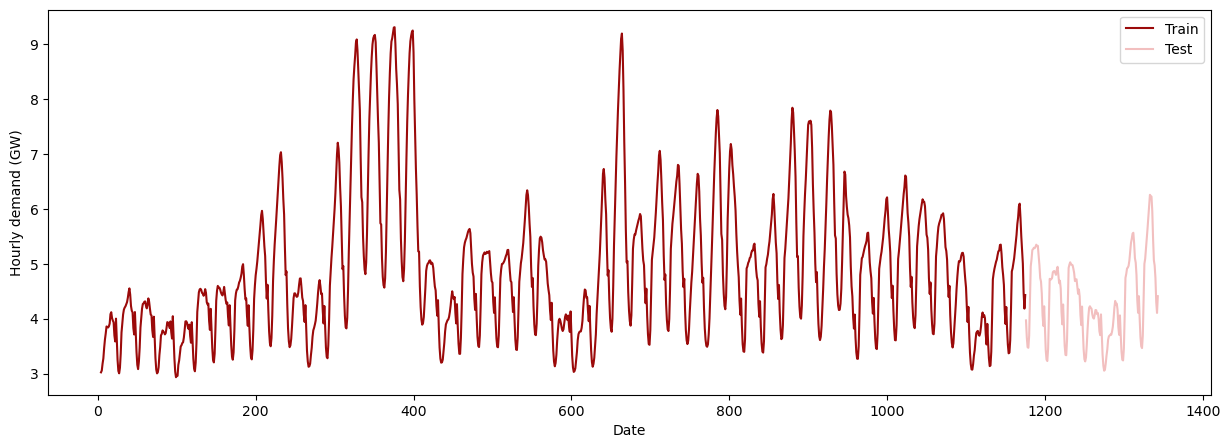

In [2]:
ts_problem = data.TimeSeriesProblem()
X_train, X_test, y_train, y_test = ts_problem.get_arrays()
ts_problem.visualize_data();

We first define perform a random search to find out which are the best hyperparameters for our random forest regressor (our base model):
- **Note:** it may take a while.

In [3]:
hyperparameters_serialization_file: str = "output/rf-hyperparameters.json"

if os.path.isfile(hyperparameters_serialization_file):
    logger.info("Retrieving best hyperparameters from local file")
    with open(hyperparameters_serialization_file, "r") as json_file:
        best_model_params: dict = json.load(json_file)
else:
    best_model_params = cv.fine_tune_rf_for_ts(X_train, y_train)
    with open(hyperparameters_serialization_file, "w") as json_file:
        json.dump(best_model_params, json_file, indent=4)

logger.info(f"The best hyperparameters found were: {best_model_params}")
best_model_params.update({'random_state': SEED, 'verbose': 0})

05/26/2024 06:34:24 PM     INFO >> Retrieving best hyperparameters from local file
05/26/2024 06:34:24 PM     INFO >> The best hyperparameters found were: {'max_depth': 23, 'n_estimators': 99}


### Training & inference

In [4]:
strategy_name: dict = {
    'EnbPI_nP': 'Ensemble of bootstrap Prediction Intervals (w/o partial fit)',
    'EnbPI': 'Ensemble of bootstrap Prediction Intervals'
}
base_model: dict = {
    'EnbPI_nP': RandomForestRegressor(**best_model_params),
    'EnbPI': RandomForestRegressor(**best_model_params)
}
y_pred, int_pred, mapie_estimator = {}, {}, {}

y_pred['EnbPI_nP'], int_pred['EnbPI_nP'], mapie_estimator['EnbPI_nP'] = ts.train_without_partial_fit(
    X_train, y_train, X_test, MISCOVERAGE, 
    RandomForestRegressor(**best_model_params)
)
y_pred['EnbPI'], int_pred['EnbPI'], mapie_estimator['EnbPI'] = ts.train(
    X_train, y_train, X_test, y_test, MISCOVERAGE, 
    RandomForestRegressor(**best_model_params)
)

05/26/2024 06:34:24 PM     INFO >> Traning EnbPI without partial fit to adjust residuals
05/26/2024 06:34:24 PM    DEBUG >>     This may take a while
05/26/2024 06:34:31 PM     INFO >> Inferring
05/26/2024 06:34:31 PM     INFO >> Traning EnbPI
05/26/2024 06:34:31 PM    DEBUG >>     This may take a while
05/26/2024 06:34:37 PM     INFO >> Inferring while adjusting residuals (partial fit)
05/26/2024 06:34:37 PM    DEBUG >>     Adjusting residuals for step 1
05/26/2024 06:34:37 PM    DEBUG >>     Adjusting residuals for step 2
05/26/2024 06:34:38 PM    DEBUG >>     Adjusting residuals for step 3
05/26/2024 06:34:38 PM    DEBUG >>     Adjusting residuals for step 4
05/26/2024 06:34:38 PM    DEBUG >>     Adjusting residuals for step 5
05/26/2024 06:34:39 PM    DEBUG >>     Adjusting residuals for step 6
05/26/2024 06:34:39 PM    DEBUG >>     Adjusting residuals for step 7
05/26/2024 06:34:39 PM    DEBUG >>     Adjusting residuals for step 8
05/26/2024 06:34:40 PM    DEBUG >>     Adjusting r

### Computing metrics

In [5]:
coverages: dict = validate.coverage(int_pred, y_test)
widths: dict = validate.width(int_pred)
rmse: dict = validate.rmse(y_pred, y_test)
cwc: dict = validate.cwc(int_pred, y_test, MISCOVERAGE, eta=10)

05/26/2024 06:35:32 PM     INFO >> Validating EnbPI_nP coverage
05/26/2024 06:35:32 PM     INFO >> Validating EnbPI coverage
05/26/2024 06:35:32 PM     INFO >> Validating EnbPI_nP width
05/26/2024 06:35:32 PM     INFO >> Validating EnbPI width
05/26/2024 06:35:32 PM     INFO >> Validating EnbPI_nP RMSE
05/26/2024 06:35:32 PM     INFO >> Validating EnbPI RMSE
05/26/2024 06:35:32 PM     INFO >> Validating EnbPI_nP CWC
05/26/2024 06:35:32 PM     INFO >> Validating EnbPI CWC


## Plotting

Let's first visualize the predicted values and intervals:

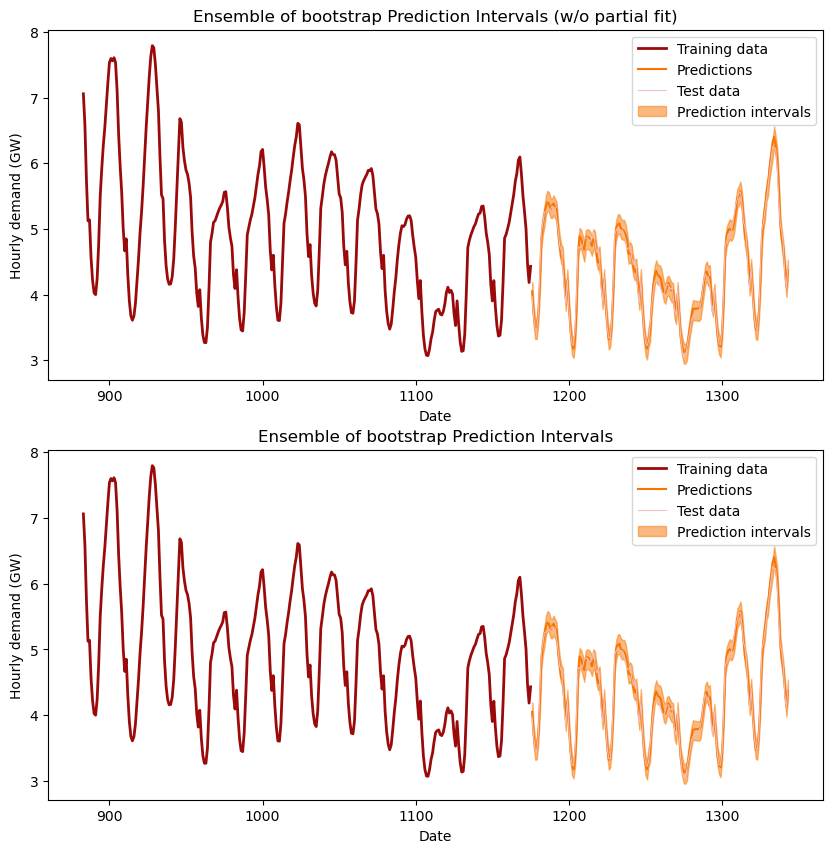

In [6]:
n_figs: int = len(base_model)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

for _i, _strat in enumerate(strategy_name.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.ts(
        points={
            'X_train': ts_problem.train_df.index.values, 
            'X': ts_problem.test_df.index.values, 
            'y_train': y_train,
            'y': y_test,
            'y_pred': y_pred[_strat],
            },
        intervals={
            'X': ts_problem.test_df.index.values, 
            'y_low': _y_pred_low, 
            'y_up': _y_pred_up
            },
        title=strategy_name[_strat], 
        ax=axs[_i]
        )
    
plt.savefig('output/prediction-intervals-timeseries-problem.png', dpi=200)
plt.show()
plt.close()

Let us assess some metrics and plot different validation figures:

### Results in function of time

- **Marginal coverage on 24h rolling windows**

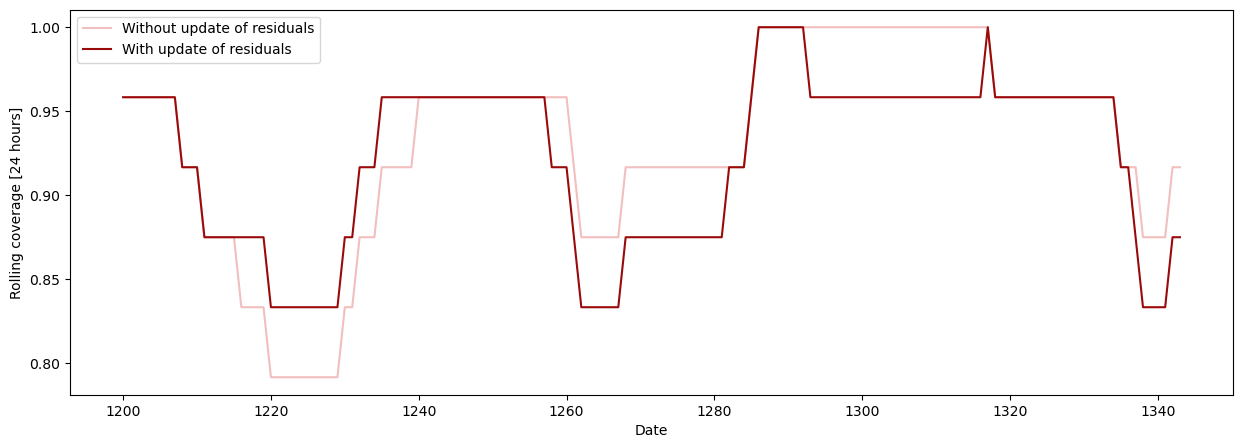

In [7]:
WINDOW_SIZE: int = 24  # in hours 
rolling_coverage = {_k: [] for _k in strategy_name.keys()}

for i in range(WINDOW_SIZE, len(y_test)):
    for _strat in strategy_name.keys():
        rolling_coverage[_strat].append(
            validate.coverage(
                {_strat: int_pred[_strat][i-WINDOW_SIZE:i, :, :]}, 
                y_test[i-WINDOW_SIZE:i], silent=True)[_strat])

visualize.rolling_coverage(
    rolling_coverage, ts_problem.test_df[WINDOW_SIZE:].index, 
    WINDOW_SIZE, save_path='output/rolling-coverage.png')

### Results aggregated in time

- **Average goodness**

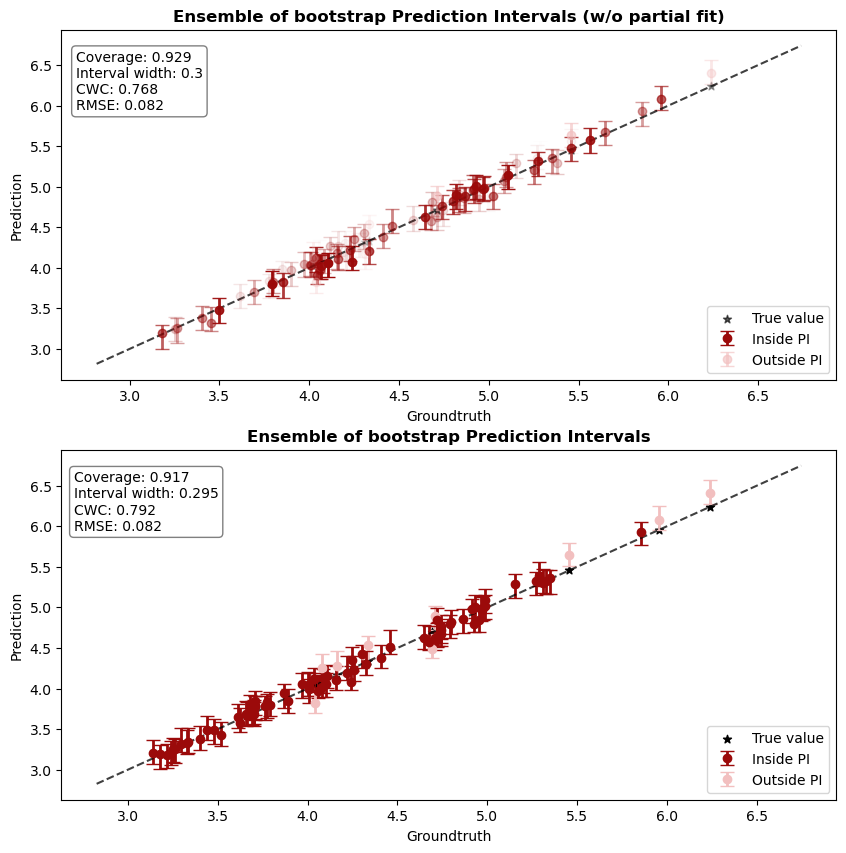

In [7]:
n_figs = len(base_model)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

for _i, _strat in enumerate(strategy_name.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.goodness(
        y_test, y_pred[_strat],
        _y_pred_low, 
        _y_pred_up,
        coverages[_strat],
        widths[_strat],
        rmse[_strat],
        cwc[_strat],
        ax=axs[_i],
        fading_with_lead_time=True if _strat == 'EnbPI_nP' else False,
        xy=(2.7, 6.5),
        xytext=(2.7, 5.95),
        subsample=0.5,
        title=strategy_name[_strat], 
    )
plt.savefig('output/average-goodness-timeseries-problem.png', dpi=200)
plt.show()
plt.close()

For visualization purposes, note that just a 50% of the test data was shown. 

- Marginal vs. conditional coverage: **width occurrence**

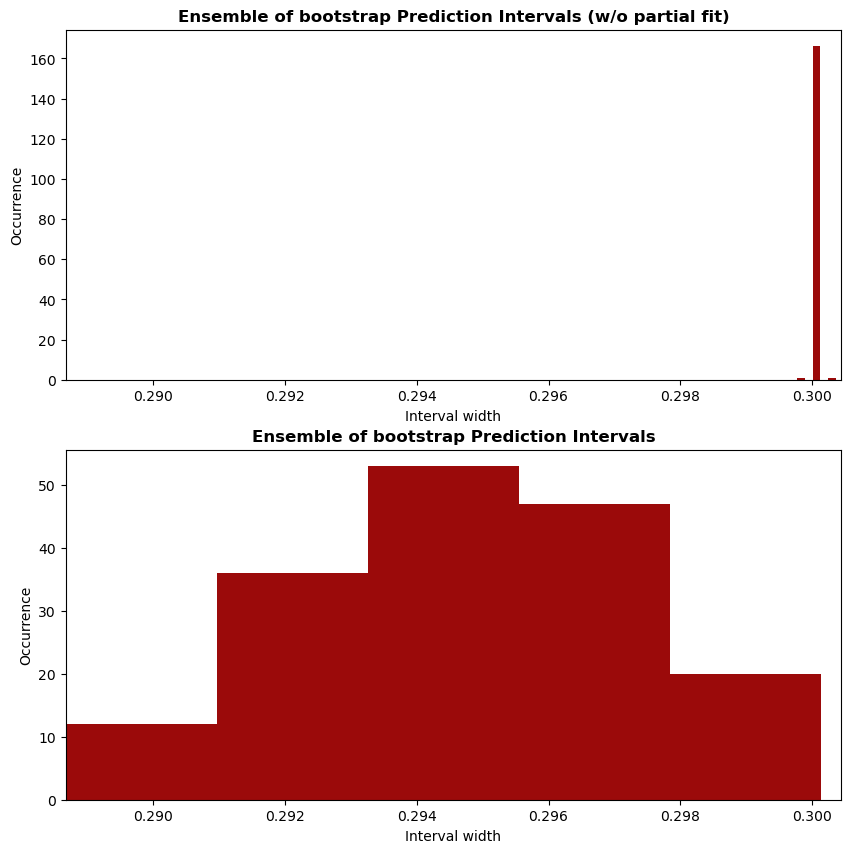

In [8]:
n_figs = len(base_model)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

_x_max = (1+1e-3) * np.max([np.abs(int_pred[_strat][:, 0, 0] - int_pred[_strat][:, 1, 0]) for _strat in int_pred.keys()]) 
_x_min = np.min([np.abs(int_pred[_strat][:, 0, 0] - int_pred[_strat][:, 1, 0]) for _strat in int_pred.keys()])

for _i, _strat in enumerate(base_model.keys()):
    # Visualize
    axs[_i] = visualize.width_size_occurrence(
        int_pred[_strat],
        # train_intervals=int_pred_train[_strat],
        num_bins=5,
        ax=axs[_i],
        x_lim=[_x_min, _x_max],
        title=strategy_name[_strat], 
    )
plt.savefig('output/width-occurrence-timeseries-problem.png', dpi=200)
plt.show()
plt.close()

- Marginal vs. conditional coverage: **coverage vs. width**
    - Since `SCP` provides constant-width intervals, its plot is omitted.

05/26/2024 04:35:27 PM  WARNING >> This metric should be used only with non constant intervals (intervals of different sizes), with constant intervals the result may be misinterpreted.
05/26/2024 04:35:27 PM  WARNING >> Size-Stratified Coverage score set to 0 for EnbPI_nP
05/26/2024 04:35:27 PM     INFO >> Validating EnbPI Size-Stratified Coverage
05/26/2024 04:35:27 PM     INFO >> Validating EnbPI_nP HSIC coefficient


05/26/2024 04:35:27 PM     INFO >> Validating EnbPI HSIC coefficient


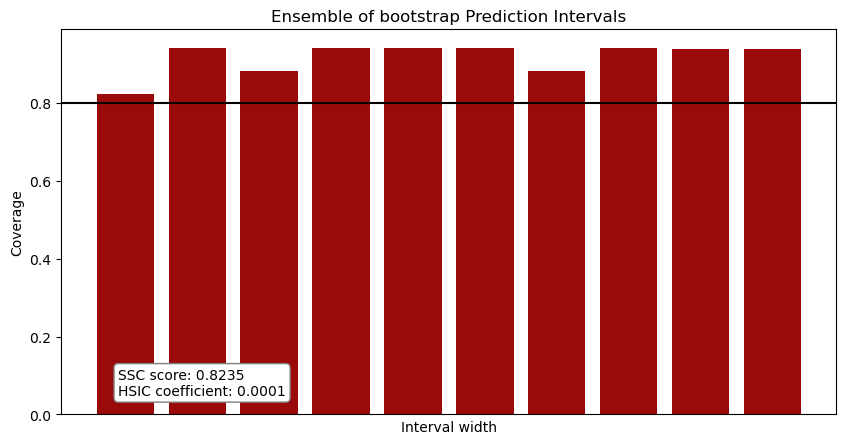

In [9]:
NUM_BINS: int = 10
_strategies = [_k for _k in base_model.keys() if _k != 'EnbPI_nP']

n_figs = len(_strategies)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));
if not hasattr(axs, '__len__'):  # because nrows=1
    axs = [axs]
    
cond_coverages: dict = validate.cond_coverage(int_pred, y_test, num_bins=NUM_BINS)
hsic_coefficients: dict = validate.hsic_coefficient(int_pred, y_test) 

for _i, _strat in enumerate(_strategies):
    axs[_i] = visualize.coverage_by_width(
        y_test, int_pred[_strat], MISCOVERAGE,
        cond_coverages[_strat],
        hsic_coefficients[_strat],
        num_bins=NUM_BINS,
        ax=axs[_i],
        title=strategy_name[_strat], 
    )
plt.savefig('output/coverage-vs-width-timeseries-problem.png', dpi=200)
plt.show()
plt.close()

For a more detailed interpretation of SSC score and the HSIC coefficient, one can refer to this [page](https://mapie.readthedocs.io/en/stable/examples_regression/2-advanced-analysis/plot_conditional_coverage.html). Below a list with the all metrics shown so far is represented.

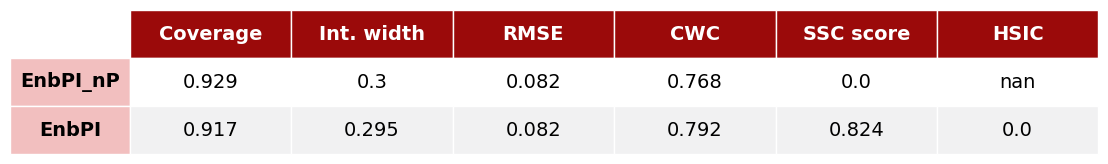

In [10]:
metrics_df = visualize.dicts_to_dataframe(
    {'Coverage': coverages, 'Int. width': widths, 
     'RMSE': rmse, 'CWC': cwc, 
     'SSC score': cond_coverages, 
     'HSIC': hsic_coefficients})

visualize.dataframe_to_png(metrics_df, 'output/metrics-table-timeseries-problem.png')

- **Coverage sougth for different values of $\alpha$**: and, finally, a visualization which displays the performance of each strategy when $\alpha$ is changed
    - Note in this case the K-fold cross-validation can not be randomly done with shuffling; instead, we need to take continuous splits of the dataset to break as much as temporal autocorrelation as possible. Actually, below a plot using a 5-fold validation is provided

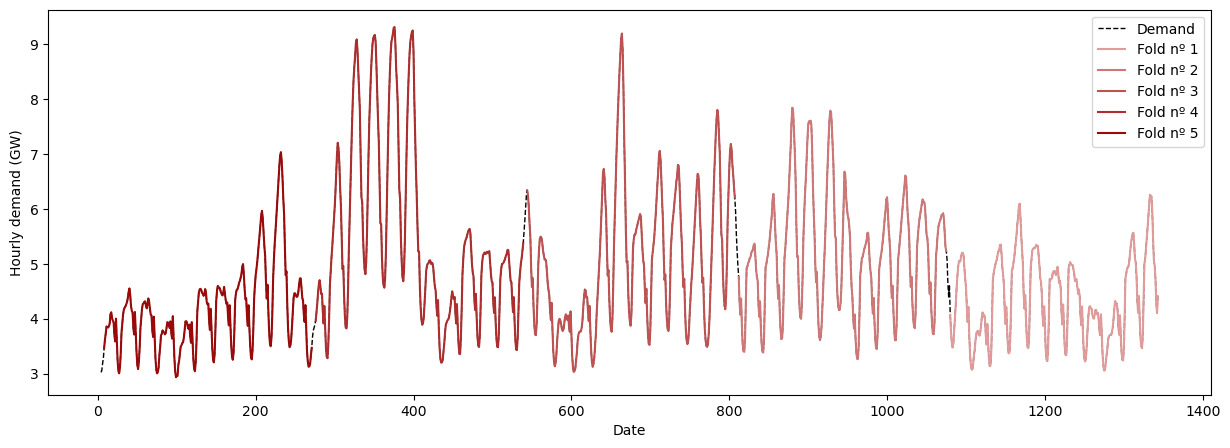

In [2]:
data.visualize_ts_K_folds(5);

- **Coverage sougth for different values of $\alpha$**
    - Below, the 5-fold CV is executed; and later its results, plotted

In [ ]:
CV_RESULTS: str = 'output/coverage-cv-results.pickle'
MISCOVERAGES_LIST: np.ndarray = np.round(np.linspace(0.01, 0.20, 5), 2)
N_FOLDS: int = 5

if os.path.isfile(CV_RESULTS):
    logger.info("Opening serialized CV results")
    with open(CV_RESULTS, 'rb') as f:
        coverages_dict = pickle.load(f)
else:
    coverages_dict = {}
    logger.info("Training the different strategis and for different alpha values")
    logger.debug(4 * " " + "This may take a while (AROUND 30' MINUTES)")

    for _strat, base_estimator in base_model.items():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            coverages_dict[_strat] = cv.ts_coverage_in_function_of_alpha(
                MISCOVERAGES_LIST, best_model_params, _strat, silent=True, K=N_FOLDS)
    
    logger.info("Serializing obtained CV results")
    with open(CV_RESULTS, 'wb') as f:
        pickle.dump(coverages_dict, f)

Now, we can proceed to plot the results:

In [ ]:
n_figs = len(base_model)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

for _i, _strat in enumerate(base_model.keys()):
    axs[_i] = visualize.coverage_by_alpha(
        coverages_dict[_strat], 
        MISCOVERAGES_LIST, 
        strategy_name[_strat],
        ax=axs[_i]
        )
plt.savefig('output/coverage-vs-alpha-timeseries-problem.png', dpi=200)
plt.show()
plt.close()